# Purpose
The purpose of this notebook is two-fold. In it, I aim to:
1. Improve the MNL model used in "Brownstone, Davide and Train, Kenneth (1999). 'Forecasting new product penetration with flexible substitution patterns'. Journal of Econometrics 89: 109-129." (p. 121).
2. 'Check' the improved MNL model for lack-of-fit between observable features of the data and predictions from the model.
3. Produce 7 plots to illustrate the general model-checking procedure.


In [1]:
import sys
from collections import OrderedDict, defaultdict

import scipy.stats
import pandas as pd
import numpy as np

import pylogit as pl

sys.path.insert(0, '../src')
from visualization import predictive_viz as viz

%matplotlib inline

/Users/timothyb0912/anaconda/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


# Load the car data

In [2]:
car_df = pd.read_csv("../data/processed/model_ready_car_data.csv")

## Create specification and name dictionaries

In [5]:
def create_specification_dict(list_of_cols_and_names):
    # Create interaction variables for the various body types
    body_names = ['sports_utility_vehicle',
                  'sports_car',
                  'station_wagon',
                  'truck',
                  'van']

    non_body_or_fuel_vars = ['price_over_log_income',
                             'price_over_log_income_lte_3',
                             'price_over_log_income_gt_3',
                             'range_over_100',
                             'acceleration_over_10',
                             'top_speed_over_100',
                             'pollution',
                             'vehicle_size_over_10',
                             'tens_of_cents_per_mile']

    body_interactions = defaultdict(lambda : [])

    for body in body_names:
        for interaction_var in non_body_or_fuel_vars:
            new_name = interaction_var + "_for_" + body
            # Store the new variable name
            body_interactions[interaction_var].append(new_name)

    # Create interaction variables for the various fuel types
    fuel_names = ['electric',
                  'compressed_natural_gas',
                  'methanol']

    fuel_interaction_vars = ['price_over_log_income',
                             'price_over_log_income_lte_3',
                             'price_over_log_income_gt_3',
                             'range_over_100',
                             'top_speed_over_100',
                             'pollution',
                             'vehicle_size_over_10',
                             'tens_of_cents_per_mile']

    fuel_interactions = defaultdict(lambda : [])

    for fuel in fuel_names:
        for interaction_var in fuel_interaction_vars:
            new_name = interaction_var + "_for_" + fuel
            # Store the new variable name
            fuel_interactions[interaction_var].append(new_name)
            
    # Create specification and name objects
    spec_dict, name_dict = OrderedDict(), OrderedDict()
            
    for col, display_name in list_of_cols_and_names:
        if col in body_interactions:
            for interaction_col in body_interactions[col]:
                suffix = interaction_col[interaction_col.rfind("for_") + 4:]
                new_display_name = display_name + " ({})".format(suffix)

                if car_df[interaction_col].unique().size == 1:
                    continue

                spec_dict[interaction_col] = 'all_same'
                name_dict[interaction_col] = new_display_name

            for interaction_col in fuel_interactions[col]:
                suffix = interaction_col[interaction_col.rfind("for_") + 4:]
                new_display_name = display_name + "({})".format(suffix)

                if car_df[interaction_col].unique().size == 1:
                    continue

                spec_dict[interaction_col] = 'all_same'
                name_dict[interaction_col] = new_display_name

        spec_dict[col] = 'all_same'
        name_dict[col] = display_name
        
    return spec_dict, name_dict


In [6]:
interaction_mnl_spec_full, interaction_mnl_names_full =\
    OrderedDict(), OrderedDict()

orig_cols_and_display_names =\
    [('price_over_log_income_lte_3', 'Price over log(income) <= 3'),
     ('price_over_log_income_gt_3', 'Price over log(income) > 3'),
     ('range_over_100', 'Range (units: 100mi)'),
     ('acceleration_over_10', 'Acceleration (units: 0.1sec)'),
     ('top_speed_over_100', 'Top speed (units: 0.01mph)'),
     ('pollution', 'Pollution'),
     ('vehicle_size_over_10', 'Size'),
     ('big_enough', 'Big enough'),
     ('luggage_space', 'Luggage space'),
     ('tens_of_cents_per_mile', 'Operation cost'),
     ('station_availability', 'Station availability'),
     ('sports_utility_vehicle', 'Sports utility vehicle'),
     ('sports_car', 'Sports car'),
     ('station_wagon', 'Station wagon'),
     ('truck', 'Truck'),
     ('van', 'Van'),
     ('electric', 'EV'),
     ('electric_commute_lte_5mi', 'Commute < 5 & EV'),
     ('electric_and_college', 'College & EV'),
     ('compressed_natural_gas', 'CNG'),
     ('methanol', 'Methanol'),
     ('methanol_and_college', 'College & Methanol')]
    
interaction_mnl_spec, interaction_mnl_names =\
    create_specification_dict(orig_cols_and_display_names)

# Estimate the model

In [7]:
# Initialize the mnl model
interaction_mnl = pl.create_choice_model(data=car_df,
                                 alt_id_col='alt_id',
                                 obs_id_col='obs_id',
                                 choice_col='choice',
                                 specification=interaction_mnl_spec_full,
                                 model_type='MNL',
                                 names=interaction_mnl_names_full)

# Create the initial variables for model estimation
num_vars = len(interaction_mnl_names_full)
initial_vals = np.zeros(num_vars)

# Estimate the mnl model
fit_vals = interaction_mnl.fit_mle(initial_vals,
                                   method='L-BFGS-B',
                                   just_point=True)['x']
# Note ridge=1e-7 produces the same results as non-regularized MLE
interaction_mnl.fit_mle(fit_vals, method='BFGS')

# Look at the estimation results
interaction_mnl.get_statsmodels_summary()

/Users/timothyb0912/anaconda/lib/python2.7/site-packages/scipy/optimize/_minimize.py:385: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  RuntimeWarning)


Log-likelihood at zero: -8,338.8486
Initial Log-likelihood: -7,311.9988


/Users/timothyb0912/anaconda/lib/python2.7/site-packages/scipy/optimize/_minimize.py:385: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.95 seconds.
Final log-likelihood: -7,311.6340


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Multinomial Logit Model Regression Results                    
===================================================================================
Dep. Variable:                      choice   No. Observations:                4,654
Model:             Multinomial Logit Model   Df Residuals:                    4,572
Method:                                MLE   Df Model:                           82
Date:                     Tue, 15 May 2018   Pseudo R-squ.:                   0.123
Time:                             07:07:28   Pseudo R-bar-squ.:               0.113
AIC:                            14,787.268   Log-Likelihood:             -7,311.634
BIC:                            15,315.798   LL-Null:                    -8,338.849
=========================================================================================================================
                                                            coef    std err          z      P>|z|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------------------------------------------
Price over log(income) <= 3 (sports_utility_vehicle)      0.2328      0.257      0.905      0.366        -0.271     0.737
Price over log(income) <= 3 (sports_car)                 -0.1069      0.253     -0.423      0.673        -0.603     0.389
Price over log(income) <= 3 (station_wagon)              -0.3201      0.109     -2.937      0.003        -0.534    -0.106
Price over log(income) <= 3 (truck)                      -0.2541      0.089     -2.863      0.004        -0.428    -0.080
Price over log(income) <= 3 (van)                        -0.2418      0.088     -2.741      0.006        -0.415    -0.069
Price over log(income) <= 3(electric)                    -0.1319      0.100     -1.324      0.186        -0.327     0.063
Price over log(income) <= 3(compressed_natural_gas)      -0.0938      0.092     -1.024      0.306        -0.273     0.086
Price over log(income) <= 3(methanol)                     0.0629      0.089      0.707      0.480        -0.112     0.237
Price over log(income) <= 3                              -0.2519      0.113     -2.225      0.026        -0.474    -0.030
Price over log(income) > 3 (sports_utility_vehicle)       0.2714      0.077      3.508      0.000         0.120     0.423
Price over log(income) > 3 (sports_car)                   0.2039      0.080      2.534      0.011         0.046     0.362
Price over log(income) > 3 (station_wagon)               -0.0341      0.047     -0.722      0.470        -0.127     0.059
Price over log(income) > 3 (truck)                       -0.0087      0.035     -0.249      0.804        -0.077     0.060
Price over log(income) > 3 (van)                         -0.0400      0.036     -1.110      0.267        -0.110     0.031
Price over log(income) > 3(electric)                     -0.0941      0.035     -2.655      0.008        -0.164    -0.025
Price over log(income) > 3(compressed_natural_gas)       -0.0534      0.033     -1.616      0.106        -0.118     0.011
Price over log(income) > 3(methanol)                     -0.0699      0.031     -2.253      0.024        -0.131    -0.009
Price over log(income) > 3                               -0.1326      0.037     -3.553      0.000        -0.206    -0.059
Range (units: 100mi) (sports_utility_vehicle)            -0.0964      0.100     -0.965      0.334        -0.292     0.099
Range (units: 100mi) (sports_car)                        -0.0721      0.117     -0.616      0.538        -0.302     0.157
Range (units: 100mi) (station_wagon)                     -0.0725      0.086     -0.848      0.397        -0.240     0.095
Range (units: 100mi) (truck)                              0.0125      0.070      0.178      0.859        -0.125     0.150
Range (units: 100mi) (van)                                0.0628      0.067      0.939      0.348        -0.068     0.194
Range (units: 100mi)(ele

# MNL Model Checking

In [8]:
# Simulate values from the sampling distribution of coefficients
cov_matrix = interaction_mnl.cov
mnl_sampling_dist =\
    scipy.stats.multivariate_normal(mean=interaction_mnl.params.values,
                                    cov=cov_matrix)

In [9]:
# Take Draws from the sampling distribution
num_draws = 1000
np.random.seed(325)
simulated_coefs = mnl_sampling_dist.rvs(num_draws)
simulated_coefs.shape

(1000, 82)

In [10]:
reload(viz)
# Predict the model probabilities
simulated_probs =\
    interaction_mnl.predict(car_df,
                            param_list=[simulated_coefs.T, None, None, None])

# Simulate y from the sampling distribution
sim_y =\
    viz.simulate_choice_vector(simulated_probs,
                               car_df['obs_id'].values,
                               rseed=1122018)

Simulating Choices: 100%|██████████| 4654/4654 [00:00<00:00, 5444.20it/s]


# Make the seven desired plots

In [11]:
import seaborn as sbn
import matplotlib.pyplot as plt

### 1. Log-Likelihood plot

/Users/timothyb0912/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


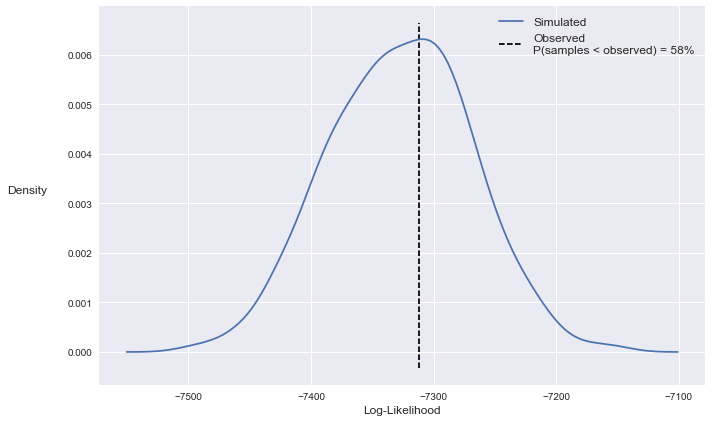

In [15]:
reload(viz)

sim_log_likes =\
    viz.compute_prior_predictive_log_likelihoods(sim_y,
                                                 car_df,
                                                 "choices",
                                                 interaction_mnl)

log_like_path = '../reports/figures/log-predictive-vehicle-choice-interaction-mnl.pdf'
# log_like_path = None
viz.plot_predicted_log_likelihoods(sim_log_likes,
                                   interaction_mnl.llf,
                                   output_file=log_like_path)

### 2. Outcome Boxplot

Unique x-values: 100%|██████████| 4/4 [00:00<00:00, 28.64it/s]


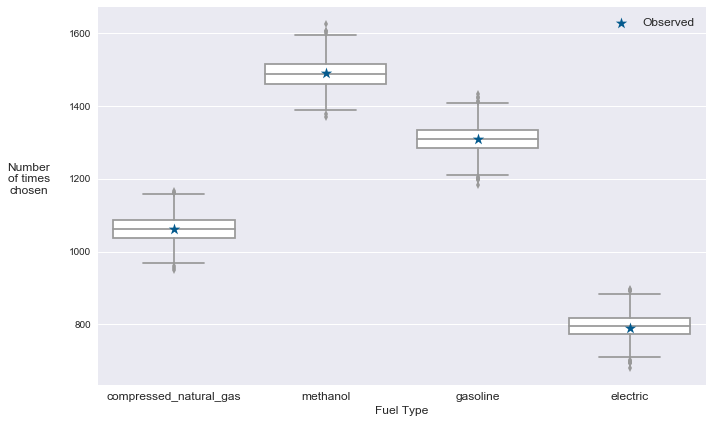

In [16]:
reload(viz)
market_path = '../reports/figures/market-share-plot-vehicle-choice-interaction-mnl.pdf'

market_dict = dict(cng='compressed_natural_gas')

viz.plot_simulated_market_shares(car_df.fuel_type.values,
                                 sim_y,
                                 car_df.choice.values,
                                 x_label='Fuel Type',
                                 y_label='Number\nof times\nchosen',
                                 display_dict=market_dict,
                                 output_file=market_path)

Unique x-values: 100%|██████████| 6/6 [00:00<00:00, 41.50it/s]


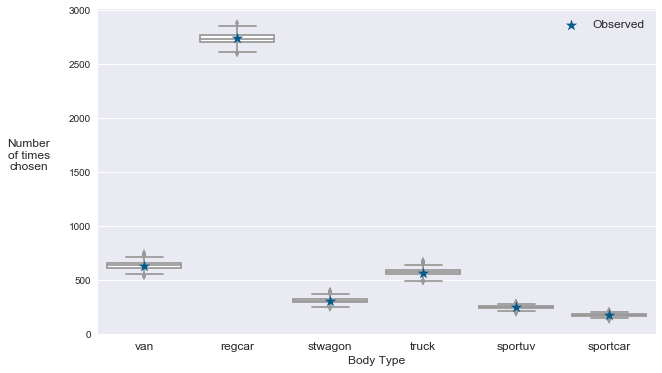

In [17]:
reload(viz)
viz.plot_simulated_market_shares(car_df.body_type.values,
                                 sim_y,
                                 car_df.choice.values,
                                 x_label='Body Type',
                                 y_label='Number\nof times\nchosen')

### 3. Binned Reliability Plot

Plotting: 100%|██████████| 1/1 [00:00<00:00, 244.57it/s]


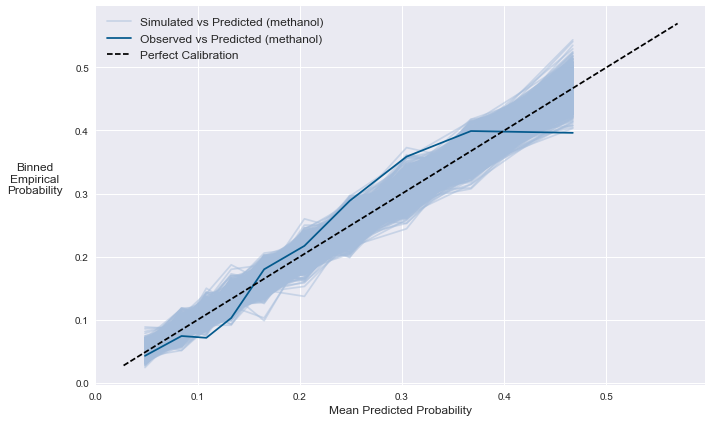

In [18]:
reload(viz)
current_fuel = 'methanol'
filter_idx = np.where((car_df.fuel_type == current_fuel).values)[0]
# current_probs = simulated_probs[filter_idx, :]
current_probs = interaction_mnl.long_fitted_probs[filter_idx]
current_choices = interaction_mnl.choices[filter_idx]
current_sim_y = sim_y[filter_idx, :]
current_line_label = 'Observed vs Predicted ({})'.format(current_fuel)
current_sim_label = 'Simulated vs Predicted ({})'.format(current_fuel)

current_sim_color = '#a6bddb'
current_obs_color = '#045a8d'

reliability_path =\
    '../reports/figures/reliability-plot-vehicle-choice-interaction-mnl-methanol-point.pdf'

viz.plot_binned_reliability(
    current_probs,
    current_choices,
    sim_y=current_sim_y,
    line_label=current_line_label,
    line_color=current_obs_color,
    sim_label=current_sim_label,
    sim_line_color=current_sim_color,
    figsize=(10, 6),
    ref_line=True,
    output_file=reliability_path)

###  4. Binned Marginal Model Plot

Plotting: 100%|██████████| 1000/1000 [00:03<00:00, 276.93it/s]


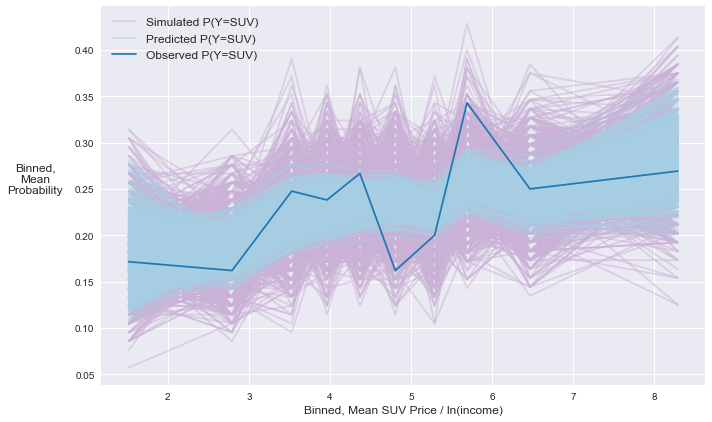

In [19]:
current_body = 'sportuv'
selection_idx = (car_df.body_type == current_body).values

num_traces = 500
current_probs = simulated_probs[selection_idx]
current_y = car_df.loc[selection_idx, 'choice'].values
current_x = car_df.loc[selection_idx, 'price_over_log_income'].values
current_sim_y = sim_y[selection_idx]

filename =\
    '../reports/figures/marginal-model-plot-vehicle-choice-interaction-mnl-suv.pdf'

viz.make_binned_marginal_model_plot(current_probs,
                                    current_y,
                                    current_x,
                                    partitions=10,
                                    sim_y=current_sim_y,
                                    y_label='Observed P(Y=SUV)',
                                    prob_label='Predicted P(Y=SUV)',
                                    sim_label='Simulated P(Y=SUV)',
                                    x_label='Binned, Mean SUV Price / ln(income)',
                                    alpha=0.5,
                                    figsize=(10, 6),
                                    output_file=filename)

### 5. Simulated Histogram

/Users/timothyb0912/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


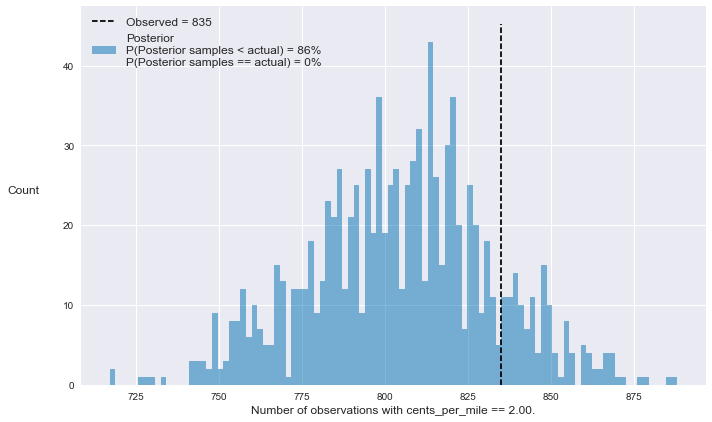

In [12]:
reload(viz)

filter_row = ((car_df.body_type == 'regcar') &
              (car_df.cents_per_mile == 2))
# current_title = 'Num Observations by Cents per Mile for Body = {}'
current_title = ''
filename =\
    '../reports/figures/histogram-vehicle-choice-interaction-mnl-regcar-operating-costs.pdf'

viz.plot_categorical_predictive_densities(
    car_df,
    None,
    sim_y,
    'cents_per_mile',
    filter_row,
    interaction_mnl.choices,
    title=current_title.format('Regular Car'),
    filter_name='observations',
    post_color=sbn.color_palette('colorblind')[0],
    figsize=(10, 6),
    legend_loc='upper left',
    output_file=filename)

### 6. Simulated KDE

Calculating KDEs: 100%|██████████| 500/500 [00:02<00:00, 211.31it/s]


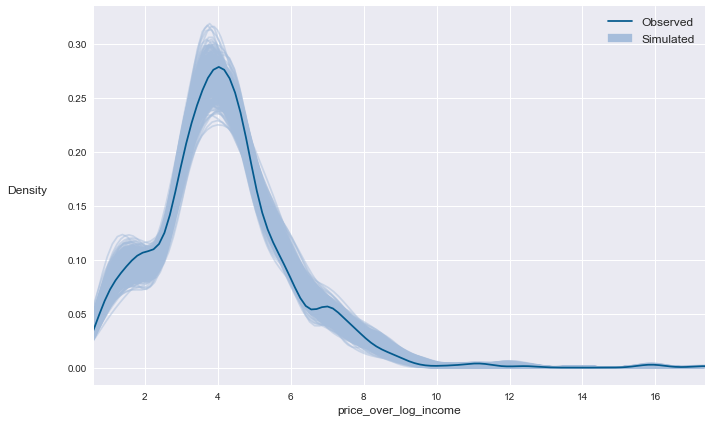

In [13]:
current_fuel = 'electric'
filter_row = car_df.fuel_type == current_fuel
# current_title = 'KDE of Price/log(income) for {} vehicles'
current_title = ''
filename =\
    '../reports/figures/kde-vehicle-choice-interaction-mnl-electric-price.pdf'

viz.plot_simulated_kde_traces(sim_y,
                              car_df,
                              filter_row,
                              'price_over_log_income',
                              'choice',
                              title=current_title.format(current_fuel),
                              figsize=(10, 6),
                              label='Simulated',
                              n_traces=500,
                              output_file=filename)

### 7. Simulated CDF

Calculating CDFs: 100%|██████████| 1000/1000 [00:03<00:00, 296.36it/s]


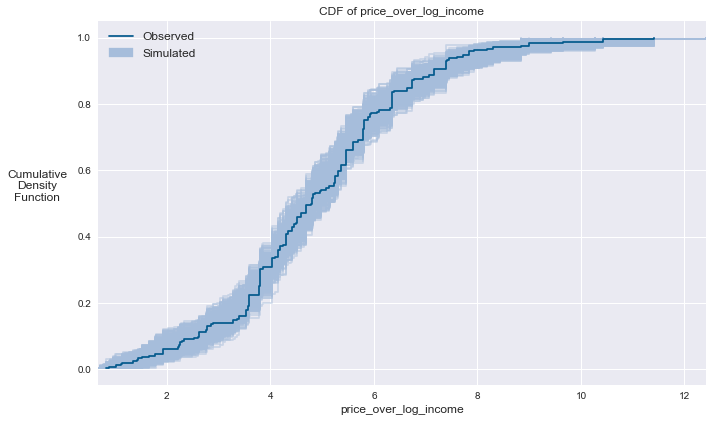

In [22]:
current_body = 'sportuv'
filter_row = car_df.body_type == current_body
# current_title =\
#     'CDF of Price/log(income) for Sport Utility Vehicles'
current_title = ''
filename =\
    '../reports/figures/cdf-vehicle-choice-interaction-mnl-suv-price.pdf'

viz.plot_simulated_cdf_traces(sim_y,
                              car_df,
                              filter_row,
                              'price_over_log_income',
                              'choice',
                              label='Simulated',
                              title=current_title,
                              figsize=(10, 6),
                              output_file=filename)

## Sandbox:
Look at additional plots

Plotting: 100%|██████████| 1000/1000 [00:03<00:00, 287.09it/s]


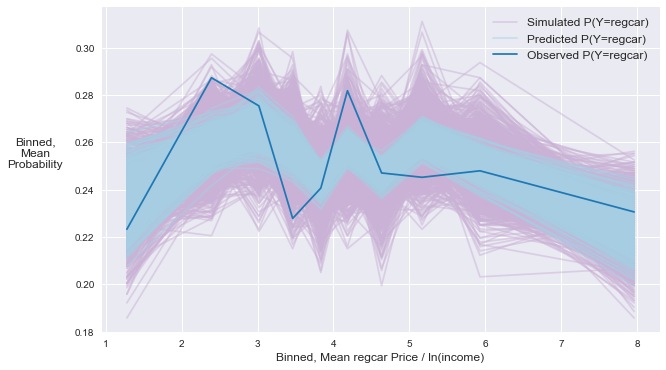

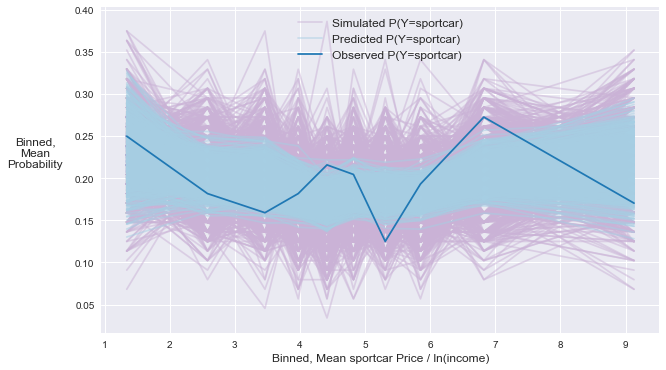

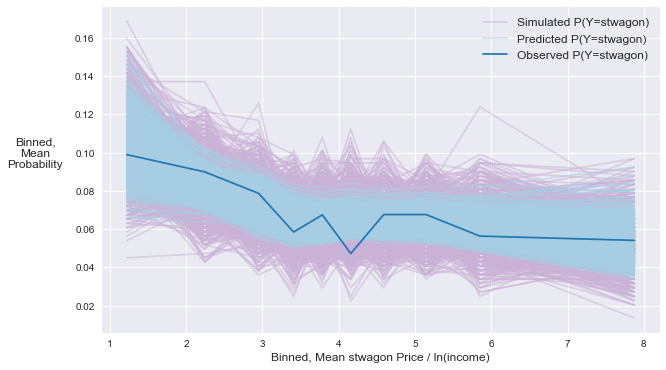

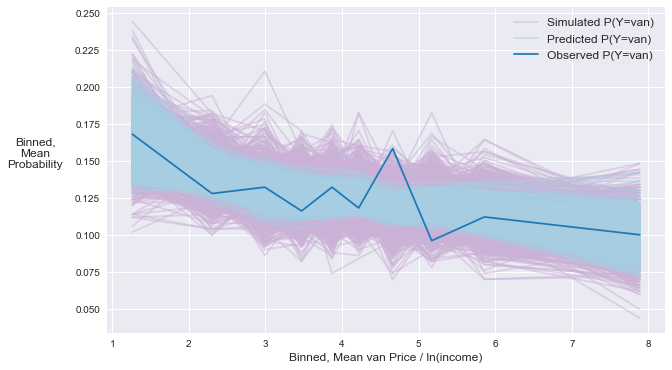

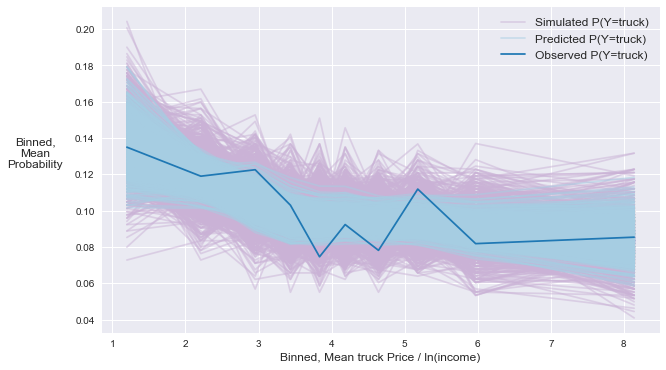

In [25]:
for body in ['regcar', 'sportcar', 'stwagon', 'van', 'truck']:
    current_body = body
    selection_idx = (car_df.body_type == current_body).values

    num_traces = 500
    current_probs = simulated_probs[selection_idx]
    current_y = car_df.loc[selection_idx, 'choice'].values
    current_x = car_df.loc[selection_idx, 'price_over_log_income'].values
    current_sim_y = sim_y[selection_idx]

    filename = None

    viz.make_binned_marginal_model_plot(current_probs,
                                        current_y,
                                        current_x,
                                        partitions=10,
                                        sim_y=current_sim_y,
                                        y_label='Observed P(Y={})'.format(body),
                                        prob_label='Predicted P(Y={})'.format(body),
                                        sim_label='Simulated P(Y={})'.format(body),
                                        x_label='Binned, Mean {} Price / ln(income)'.format(body),
                                        alpha=0.5,
                                        figsize=(10, 6),
                                        output_file=filename)

Calculating CDFs: 100%|██████████| 1000/1000 [00:03<00:00, 275.84it/s]


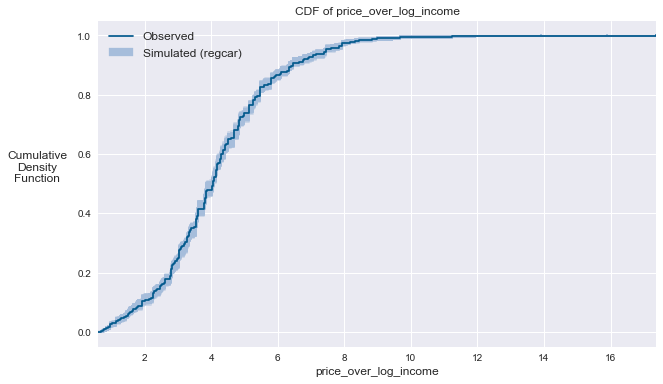

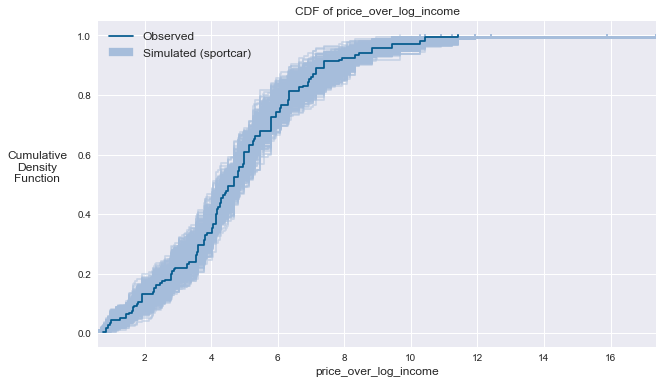

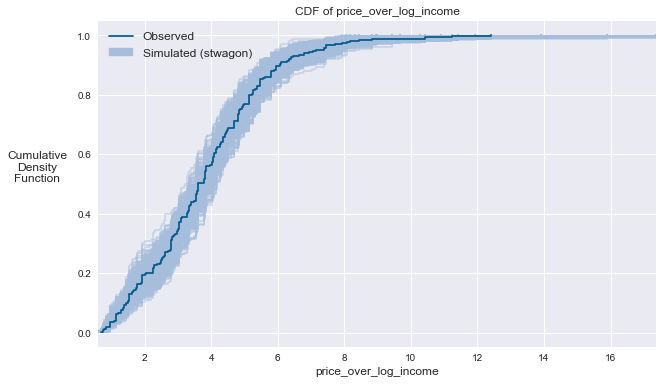

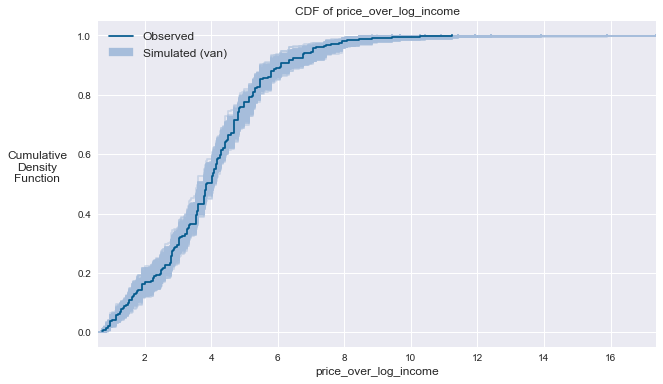

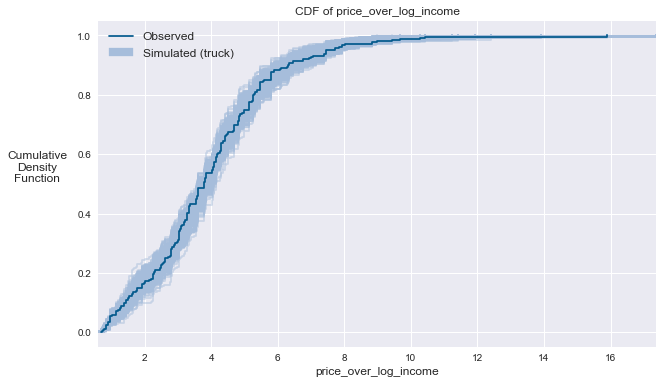

In [27]:
for body in ['regcar', 'sportcar', 'stwagon', 'van', 'truck']:
    current_body = body
    filter_row = car_df.body_type == current_body
    # current_title =\
    #     'CDF of Price/log(income) for Sport Utility Vehicles'
    current_title = ''
    filename = None
    viz.plot_simulated_cdf_traces(sim_y,
                                  car_df,
                                  filter_row,
                                  'price_over_log_income',
                                  'choice',
                                  label='Simulated ({})'.format(body),
                                  title=current_title,
                                  figsize=(10, 6),
                                  output_file=filename)

Plotting: 100%|██████████| 1/1 [00:00<00:00, 233.74it/s]


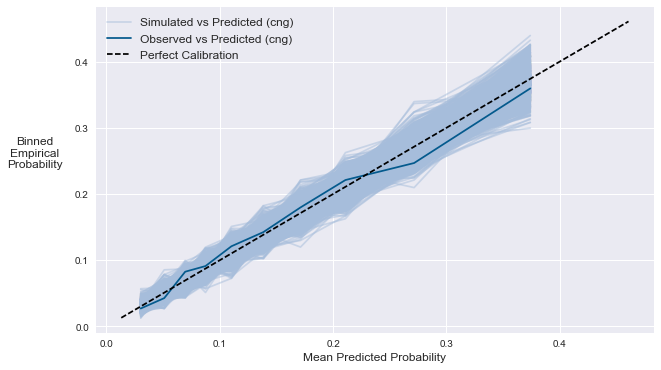

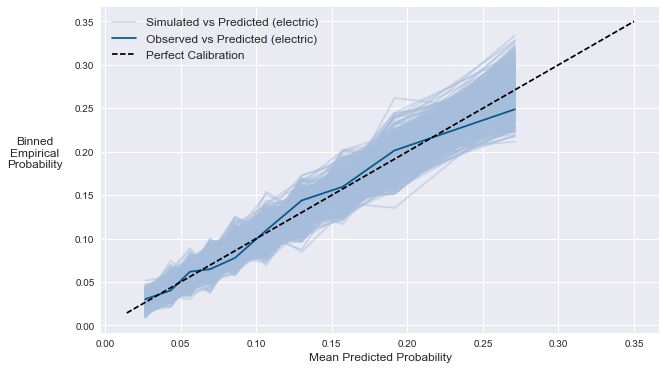

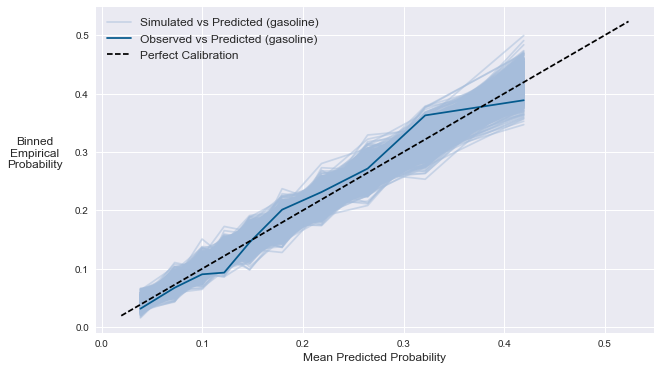

In [28]:
for fuel in ['cng', 'electric', 'gasoline']:
    reload(viz)
    current_fuel = fuel
    filter_idx = np.where((car_df.fuel_type == current_fuel).values)[0]
    # current_probs = simulated_probs[filter_idx, :]
    current_probs = interaction_mnl.long_fitted_probs[filter_idx]
    current_choices = interaction_mnl.choices[filter_idx]
    current_sim_y = sim_y[filter_idx, :]
    current_line_label = 'Observed vs Predicted ({})'.format(current_fuel)
    current_sim_label = 'Simulated vs Predicted ({})'.format(current_fuel)

    current_sim_color = '#a6bddb'
    current_obs_color = '#045a8d'

    reliability_path = None
    viz.plot_binned_reliability(
        current_probs,
        current_choices,
        sim_y=current_sim_y,
        line_label=current_line_label,
        line_color=current_obs_color,
        sim_label=current_sim_label,
        sim_line_color=current_sim_color,
        figsize=(10, 6),
        ref_line=True,
        output_file=reliability_path)

In [1]:
-2 * -7375.19 + 2 * 25

14800.38